In [1]:
# with augmentation

In [2]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:,.3f}'.format

%matplotlib inline

In [3]:
model_name = 'model-2a-lvfx'
shuffle_clusters = True

data = DataModel('data-mtx-enough-top-6.npz', 
                 batch_size = 64, validation_percent = .05, test_percent = .1)
data.append_dim = True

ai = AI(data, model_name)

np.random.seed(888)
ai.data.shuffle(only_train=False)

if shuffle_clusters:
    ai.data.shuffle_training_clusters()

ai.data.weight_non_compton = .5
ai.weight_type = .05
ai.weight_e_cluster = .15
ai.weight_p_cluster = .1
ai.weight_pos_x = 12
ai.weight_pos_y = 2
ai.weight_pos_z = 8
ai.weight_energy = 7

In [4]:
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64], energy_layers=[32], base_l2=.000, limbs_l2=.000)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 54, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 6, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 6, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 384)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [5]:
ai.load('stage-1/'+model_name[:-1], optimizer=False)
ai.compile_model(learning_rate=0.0002)
ai.model.fit(ai.data.generate_batch(),epochs=1, steps_per_epoch=1, verbose=0)

ai.load('stage-1/'+model_name[:-1], optimizer=True)

In [6]:
lr_decay = keras.optimizers.schedules.PolynomialDecay(
    decay_steps=300,
    initial_learning_rate=.0002,
    end_learning_rate=.000001, 
    power=1.75)

def lr_scheduler(epoch):
    start = 0
    return lr_decay(start+epoch)
        
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [7]:
%%time
ai.train(epochs=300, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

17443/17443 [==============================] - 29s 2ms/step - loss: 0.4219 - e_cluster_loss: 0.0328 - p_cluster_loss: 0.0812 - type_loss: 0.3099 - pos_x_loss: 4.7498e-04 - pos_y_loss: 0.0374 - pos_z_loss: 3.4795e-04 - energy_loss: 0.0443 - e_cluster__cluster_accuracy: 0.9539 - p_cluster__cluster_accuracy: 0.8863 - type__type_accuracy: 0.8674 - type__type_tp_rate: 0.8633

CPU times: user 3d 19h 33min 24s, sys: 2h 38min 1s, total: 3d 22h 11min 26s
Wall time: 3d 22h 27min 31s


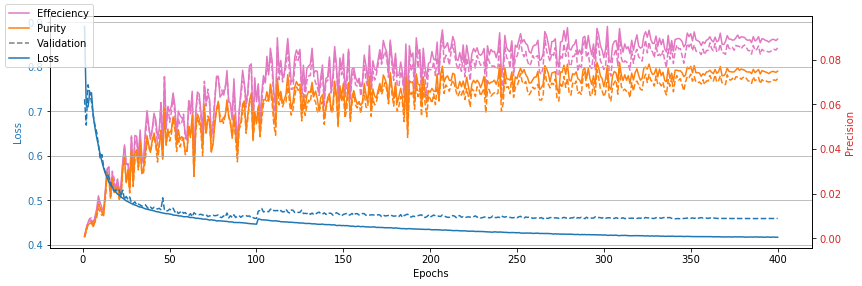

In [8]:
ai.plot_training_loss(smooth=False)

In [9]:
ai.evaluate()

AI model
  Loss:        0.46303
    -Type:         0.31151 *  0.05 = 0.01558
    -Pos X:        0.00036 * 12.00 = 0.00432
    -Pos Y:        0.03793 *  2.00 = 0.07587
    -Pos Z:        0.00032 *  8.00 = 0.00258
    -Energy:       0.05017 *  7.00 = 0.35121
    -Cls e:        0.03504 *  0.15 = 0.00526
    -Cls p:        0.08219 *  0.10 = 0.00822
  Accuracy:    0.86608
    -TP rate:      0.86246
    -Cls e rate:   0.95194
    -Cls p rate:   0.88704
  Efficiency:  0.08964
  Purity:      0.07547
  Euc mean:   11.77544
  Euc std:    31.03561

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [10]:
ai.save(file_name=model_name)